In [1]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import Normalize, ToTensor, Compose, Resize
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image

In [2]:
# see dimensions of images

data_dir = 'data/train/images'

# Iterate over the image files
for filename in os.listdir(data_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Construct the full path to the image file
        img_path = os.path.join(data_dir, filename)
        
        # Open the image
        img = Image.open(img_path)
        
        # Get the dimensions of the image
        WIDTH, HEIGHT = img.size
        print(f"Image '{filename}' dimensions: {WIDTH} x {HEIGHT}")

        # Close the image
        img.close()
        break

Image 'volume_136_slice_91_jpg.rf.7fabaa68b1d50a7a2897d568201d9403 2.jpg' dimensions: 139 x 132


In [3]:
base_transform = Compose([
    # Resize((256, 256)),
    ToTensor(),
])

In [4]:
# convert the label from YOLO format to [x_min, y_min, x_max, y_max] in pixel units
def convert_label(label):
    class_ = label[0].item()
    x_center = label[1].item()
    y_center = label[2].item()
    width = label[3].item()
    height = label[4].item()
    x_lower = round(WIDTH * (x_center - width/2))
    x_upper = round(WIDTH * (x_center + width/2))
    y_lower = round(HEIGHT * (y_center - height/2))
    y_upper = round(HEIGHT * (y_center + height/2))
    box = [x_lower, y_lower, x_upper, y_upper]
    return class_, box

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir_images, root_dir_labels, transform=None):
        self.root_dir_images = root_dir_images
        self.root_dir_labels = root_dir_labels
        self.transform = transform

        # Get list of image and label filenames
        self.image_files = [f for f in os.listdir(root_dir_images) if f.endswith('.jpg')]
        self.label_files = [f for f in os.listdir(root_dir_labels) if f.endswith('.txt')]

        # Extract common filenames without extension
        self.image_names = [os.path.splitext(f)[0] for f in self.image_files]
        self.label_names = [os.path.splitext(f)[0] for f in self.label_files]

        # Find matching image-label pairs
        self.matched_files = list(set(self.image_names) & set(self.label_names))

    def __len__(self):
        return len(self.matched_files)

    def __getitem__(self, idx):
        name = self.matched_files[idx]
        img_path = os.path.join(self.root_dir_images, name + '.jpg')
        label_path = os.path.join(self.root_dir_labels, name + '.txt')

        image = Image.open(img_path)
        with open(label_path, 'r') as file:
            label_str = file.readline().strip()
            label = [float(x) for x in label_str.split()]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

In [7]:
# Define paths to your data
data_dir = 'data'
train_dir_images = os.path.join(data_dir, 'train', 'images')
train_dir_labels = os.path.join(data_dir, 'train', 'labels')

# Create datasets
train_dataset = CustomDataset(root_dir_images=train_dir_images, root_dir_labels=train_dir_labels, transform=base_transform)
# valid_dataset = CustomDataset(root_dir_images=valid_dir_images, root_dir_labels=valid_dir_labels, transform=base_transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [8]:
# Get mean and std using a subset of training data

mean = torch.zeros(3)
std = torch.zeros(3)

SUBSET_SIZE = 1000

# Create a subset of the dataset
subset_indices = torch.randperm(len(train_dataset))[:SUBSET_SIZE]
subset = torch.utils.data.Subset(train_dataset, subset_indices)

# Calculate mean and std of each channel
for image, label in subset:
    mean += image.mean(dim = (1,2))
    std += image.std(dim = (1,2))

mean /= len(subset)
std /= len(subset)
print("Mean:", mean)
print("Standard deviation:", std)

Mean: tensor([0.1810, 0.1509, 0.1598])
Standard deviation: tensor([0.1454, 0.1300, 0.1276])


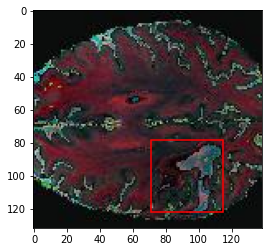

tensor([1.0000, 0.6691, 0.7576, 0.3165, 0.3333])
[71, 78, 115, 122]


In [16]:
# Visualize an image
image, label = subset[0]
image_np = image.permute(1, 2, 0).numpy()
img_class, img_box = convert_label(label)
# add rectangle displaying object location
rect = patches.Rectangle((img_box[0], img_box[1]), img_box[2] - img_box[0], img_box[3] - img_box[1],
                         linewidth = 1.5, edgecolor = 'r', facecolor = 'None')
fig, ax = plt.subplots()
ax.imshow(image_np)
ax.add_patch(rect)
plt.show()
print(label)
print(img_box)

In [17]:
# final transformation
train_transform = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(degrees=15),     # Random rotation by 15 degrees
    transforms.RandomCrop((139, 132), padding = 4),         # Random crop to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  # Apply normalization using the computed mean and std
])

val_transform = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  # Apply normalization using the computed mean and std
])

In [18]:
valid_dir_images = os.path.join(data_dir, 'valid', 'images')
valid_dir_labels = os.path.join(data_dir, 'valid', 'labels')

# Recreate datasets
train_dataset = CustomDataset(root_dir_images=train_dir_images, root_dir_labels=train_dir_labels, transform=train_transform)
valid_dataset = CustomDataset(root_dir_images=valid_dir_images, root_dir_labels=valid_dir_labels, transform=val_transform)

# Recreate DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [19]:
len(train_dataset)

6930

Number of Positive Training Samples: 2613
Number of Negative Training Samples: 4238


<BarContainer object of 2 artists>

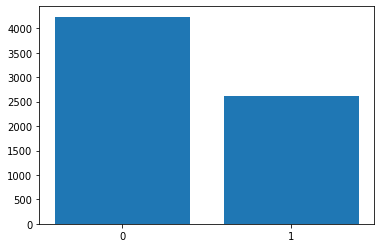

In [25]:
# Explore distribution of response class

count_0 = 0
count_1 = 0
for img, label in train_dataset:
    if len(label) == 0:
        continue
    if label[0].item() == 0:
        count_0 += 1
    else:
        count_1 += 1

print(f"Number of Positive Training Samples: {count_1}")
print(f"Number of Negative Training Samples: {count_0}")
plt.bar(["0","1"], [count_0, count_1])